# Resampling

Working with imbalanced data has a lot of downsides. In this notebook we will look at the influence of resampling of the imbalanced data for active learning.

By using resampling we can remove some samples from the larger class and add some samples to the smaller class.

[See here](https://www.kaggle.com/code/rafjaa/resampling-strategies-for-imbalanced-datasets) for more info on resampling.
We will use the [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn) library for this.

In [66]:
## Imports ##

# numpy
import numpy as np
import math

# matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# skactiveml
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.pool import RandomSampling
from skactiveml.utils import MISSING_LABEL

# imbalanced-learn
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks 
from imblearn.over_sampling import SMOTE, KMeansSMOTE, ADASYN

# plot function
from plot_accuracy import plot_accuracy

# balanced accuracy
from balanced_accuracy import balanced_accuracy

# set warnings
import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

In [55]:
def check_k_presence(y, k):

    classes = np.unique(y)
    for cls in classes:
       if list(y).count(cls) < k and not math.isnan(cls):
           return False
    return True

In [52]:
def get_balanced_accuracy(weights=None, cycles=30, n_samples=400, resampling=None, k=6, **kwargs):
    data = []
    for rand in range(100):
        Xc, yc = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, weights=weights, random_state=rand);
        Xf, Xt, yf, yt = train_test_split(Xc, yc, random_state=rand)
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)
        out = []
        clf = SklearnClassifier(LogisticRegression(), classes=np.unique(yf))
        qs = UncertaintySampling(random_state=rand, **kwargs)
        if resampling != None:
            resampler = resampling()

        clf.fit(Xf, y)
        for _ in range(cycles):
            i = qs.query(Xf, y, clf)
            y[i] = yf[i]
            # resample the the data
            if resampling != None and check_k_presence(y, k):
                Xr, yr = resampler.fit_resample(Xf, [-1 if math.isnan(x) else x for x in y])
                clf.fit(Xr,[MISSING_LABEL if x == -1 else x for x in yr])
            else:
                clf.fit(Xf, y)
            out.append(balanced_accuracy(yt,clf.predict(Xt))) 
        data.append(out)

    return np.mean(np.array(data), axis=0)

In [53]:
data_normal = get_balanced_accuracy(weights=[0.8,0.2])

In [59]:
data_Tomek = get_balanced_accuracy(weights=[0.8,0.2], resampling=TomekLinks)

In [63]:
data_SMOTE = get_balanced_accuracy(weights=[0.8,0.2], resampling=SMOTE)

In [67]:
data_ADASYN = get_balanced_accuracy(weights=[0.8,0.2], resampling=ADASYN)

In [68]:
data_KMeansSMOTE = get_balanced_accuracy(weights=[0.8,0.2], resampling=KMeansSMOTE)

RuntimeError: No clusters found with sufficient samples of class 0.0. Try lowering the cluster_balance_threshold or increasing the number of clusters.

In [57]:
data_SMOTEENN = get_balanced_accuracy(weights=[0.8,0.2], resampling=SMOTEENN)

In [58]:
data_SMOTETomek = get_balanced_accuracy(weights=[0.8,0.2], resampling=SMOTETomek)

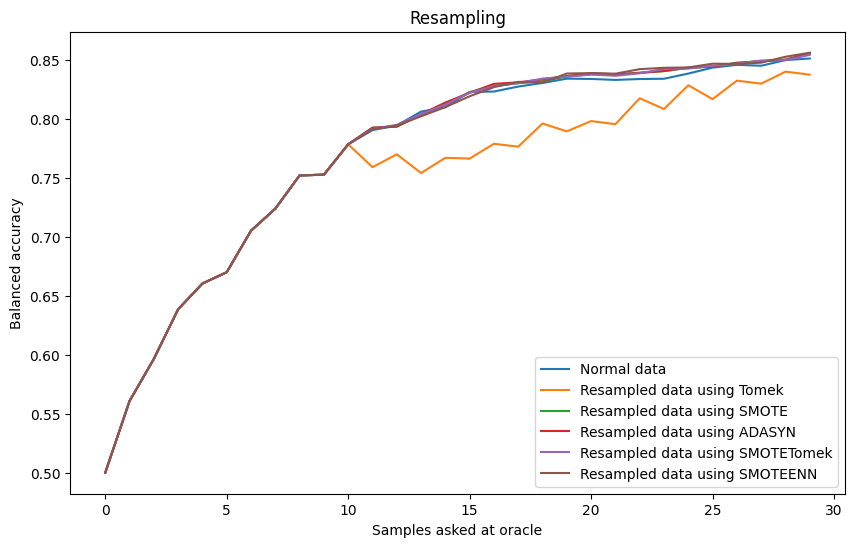

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

plot_accuracy('Resampling',[[data_normal, 'Normal data'],
                            [data_Tomek, 'Resampled data using Tomek'],
                            [data_SMOTE, 'Resampled data using SMOTE'],
                            [data_ADASYN, 'Resampled data using ADASYN'],
                            [data_SMOTETomek, 'Resampled data using SMOTETomek'],
                            [data_SMOTEENN, 'Resampled data using SMOTEENN']],
                            
                            axs)
fig.show()